# Dataset

In [70]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import RandomForestClassifier


In [36]:
df_magic = pd.read_csv('magic04.data', header = None)
df_magic.columns = ['Lenght', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans', 'Alpha', 'Dist', 'Class']
le = LabelEncoder()
y = le.fit_transform(df_magic['Class'].values)
df_magic['Class'] = y

In [37]:
df_magic

,Lenght,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,Class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,0
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,0
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,0
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,0
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,0
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,1
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,1
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,1
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,1


In [75]:
X,y  = df_magic.iloc[:,:-1].values, df_magic.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state= 0, stratify= y, shuffle= True)
X_train = X_train[:100]
X_test = X_test[:100]
y_train = y_train[:100]
y_test = y_test[:100]


## Scaling


In [39]:

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

## Logistic Regression

In [40]:
lr = LogisticRegression(random_state= 1, solver = 'lbfgs')
#Creo una pipeline in cui viene fatto lo scaling e poi la stima con il classificatore
pipe_lr = make_pipeline(StandardScaler(), lr)

#Tuning dei parametri
C_range = [0.0001,0.001,0.01, 0.1, 1, 10, 100,1000]
max_iter = [100,500, 1000]
param_grid_lr = [{'logisticregression__C': C_range, 'logisticregression__max_iter':max_iter}]

gs_lr = GridSearchCV(estimator= pipe_lr, param_grid= param_grid_lr, scoring= 'accuracy', refit= True, cv = 10)
gs_lr.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=1))]),
             param_grid=[{'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                    10, 100, 1000],
                          'logisticregression__max_iter': [100, 500, 1000]}],
             scoring='accuracy')

In [41]:
best_lr_acc = gs_lr.best_estimator_
best_lr_acc.fit(X_train, y_train)
#valuto lo score con la cross validation ossia lo score ottenuto sul validation dataset con quei valori degli iperparametri scelti.
scores = cross_val_score(estimator= best_lr_acc, X = X_train, y = y_train, cv =10)
print('Cross validation accuracy: ', np.mean(scores))
print('Accuracy del modello sul test data:', best_lr_acc.score(X_test, y_test))
print('Accuracy del modello sul train:', best_lr_acc.score(X_train, y_train))


Cross validation accuracy:  0.785
Accuracy del modello sul test data: 0.79
Accuracy del modello sul train: 0.795


In [42]:
best_lr_acc.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.1, random_state=1))])>

In [43]:
gs_lr.best_params_

{'logisticregression__C': 0.1, 'logisticregression__max_iter': 100}

## Logistic regression + feature selection

In [44]:
sbs = SequentialFeatureSelector(estimator = lr, scoring = 'accuracy' )
#sbs.fit(X_train, y_train)
pipe_lr_sbs = make_pipeline(StandardScaler(), sbs, lr)
n_components = [6,7]
C_range = [0.1,1,10,100]
param_grid_lr_sbs = [{'logisticregression__C': C_range, 'logisticregression__max_iter':max_iter, 
'sequentialfeatureselector__n_features_to_select': n_components}]
gs_lr_sbs = GridSearchCV(estimator= pipe_lr_sbs, param_grid= param_grid_lr_sbs, cv = 10, refit= True)
gs_lr_sbs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('sequentialfeatureselector',
                                        SequentialFeatureSelector(estimator=LogisticRegression(random_state=1),
                                                                  scoring='accuracy')),
                                       ('logisticregression',
                                        LogisticRegression(random_state=1))]),
             param_grid=[{'logisticregression__C': [0.1, 1, 10, 100],
                          'logisticregression__max_iter': [100, 500, 1000],
                          'sequentialfeatureselector__n_features_to_select': [6,
                                                                              7]}])

In [45]:
best_lr_sbs_acc = gs_lr_sbs.best_estimator_
best_lr_sbs_acc.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sequentialfeatureselector',
                 SequentialFeatureSelector(estimator=LogisticRegression(random_state=1),
                                           n_features_to_select=6,
                                           scoring='accuracy')),
                ('logisticregression',
                 LogisticRegression(C=100, random_state=1))])>

In [46]:
#print(pipe_lr_sbs.get_params)
#features = sbs.get_feature_names_out(df_magic.columns[:-1])
#print(features)
#X_train_sbs = sbs.transform(X_train)
#X_test_sbs = sbs.transform(X_test)

In [47]:
print(best_lr_sbs_acc)
best_lr_sbs_acc.fit(X_train, y_train)
#print(pipe_lr.score(X_test_sbs, y_test))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sequentialfeatureselector',
                 SequentialFeatureSelector(estimator=LogisticRegression(random_state=1),
                                           n_features_to_select=6,
                                           scoring='accuracy')),
                ('logisticregression',
                 LogisticRegression(C=100, random_state=1))])


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sequentialfeatureselector',
                 SequentialFeatureSelector(estimator=LogisticRegression(random_state=1),
                                           n_features_to_select=6,
                                           scoring='accuracy')),
                ('logisticregression',
                 LogisticRegression(C=100, random_state=1))])

In [48]:
scores = cross_val_score(estimator= best_lr_sbs_acc, X = X_train, y = y_train, cv = 10)
print('CV accuracy score:', np.mean(scores))
print('Accuracy sul test data:',best_lr_sbs_acc.score(X_test, y_test))
print('Accuracy sul train data:', best_lr_sbs_acc.score(X_train, y_train))

CV accuracy score: 0.8100000000000002
Accuracy sul test data: 0.815
Accuracy sul train data: 0.82


## Logistic regression + PCA

In [49]:

pca = PCA(n_components = None)
#Dividio il train in train e validation (holdhout method)
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train_std, y_train, test_size= 0.3, random_state= 0 , stratify= y_train)
pca.fit(X_train_2)



PCA()

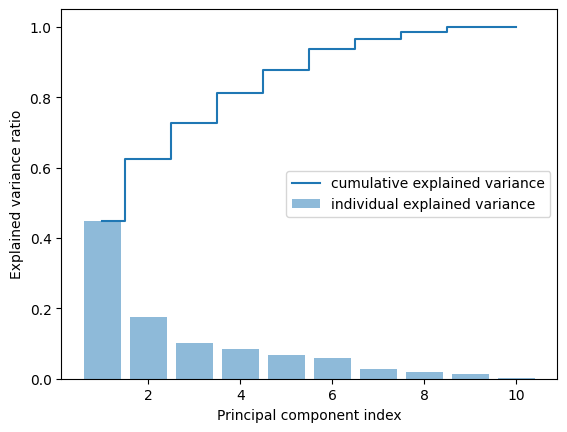

In [50]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.bar(range(1,11), pca.explained_variance_ratio_, alpha  = 0.5, align = 'center', label = 'individual explained variance')
plt.step(range(1,11), cum_var_exp , where = 'mid', label = 'cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc = 'best')
plt.show()

In [51]:
n_components = [6,7]
pipe_lr_pca = make_pipeline(StandardScaler(), pca, lr)
param_grid_lr_pca = [{'logisticregression__C': C_range, 'logisticregression__max_iter': max_iter, 'pca__n_components': n_components}]
gs_lr_pca = GridSearchCV(estimator= pipe_lr_pca, param_grid= param_grid_lr_pca, cv = 10, scoring =  'accuracy', refit= True)
gs_lr_pca.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=1))]),
             param_grid=[{'logisticregression__C': [0.1, 1, 10, 100],
                          'logisticregression__max_iter': [100, 500, 1000],
                          'pca__n_components': [6, 7]}],
             scoring='accuracy')

In [52]:
best_lr_pca_acc = gs_lr_pca.best_estimator_
best_lr_pca_acc.fit(X_train, y_train)
#valuto lo score con la cross validation ossia lo score ottenuto sul validation dataset con quei valori degli iperparametri scelti.
scores = cross_val_score(estimator= best_lr_pca_acc, X = X_train, y = y_train, cv =10)
print('Cross validation accuracy: ', np.mean(scores))
print('Accuracy del modello sul test data:', best_lr_pca_acc.score(X_test, y_test))
print('Accuracy del modello sul train:', best_lr_pca_acc.score(X_train, y_train))

Cross validation accuracy:  0.78
Accuracy del modello sul test data: 0.8
Accuracy del modello sul train: 0.79


In [53]:
print(best_lr_pca_acc)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=7)),
                ('logisticregression',
                 LogisticRegression(C=1, random_state=1))])


In [54]:
#param_range = [0.0001,0.001,0.01, 0.1, 1, 10, 100,1000]
#param_range_2 = [1,2,3,4,5,6,7,8,9]
#param_grid = [{'logisticregression__C': param_range, 'pca__n_components': param_range_2}]
#gs = GridSearchCV(estimator= pipe_lr, param_grid=param_grid, cv = 10, refit = True, scoring = 'accuracy') 

In [55]:
#gs.fit(X_train, y_train)
#print(gs.best_params_, gs.best_score_)

In [56]:
#pipe_lr = gs.best_estimator_
pipe_lr.fit(X_train, y_train)

scores = cross_val_score(estimator= pipe_lr, X= X_train, y = y_train, cv = 10)
print('CV accuracy:', np.mean(scores))
print('Accuracy on test data:', pipe_lr.score(X_test, y_test))
print('Accuracy on train data:', pipe_lr.score(X_train, y_train))
#print(np.mean(cross_val_score(estimator= pipe_lr, X = X_train, y = y_train, cv = 10)))

CV accuracy: 0.7849999999999999
Accuracy on test data: 0.805
Accuracy on train data: 0.79


In [58]:
pipe_lr = make_pipeline(StandardScaler(), pca, lr)

param_range = [1,5,10,15,20,25,30,35]
#comp_range = [1,2,4,5,6,7,8,9]
C_range = [0.0001,0.001,0.01, 0.1, 1, 10, 100,1000]
#pipe_lr = make_pipeline(StandardScaler(),kpca, lr)
param_grid = {'pca__n_components': n_components, 'logisticregression__C':C_range, 'logisticregression__solver':['lbfgs']}
gs = GridSearchCV(estimator= pipe_lr, param_grid= param_grid, cv = 10, scoring= 'accuracy')
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=1))]),
             param_grid={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   10, 100, 1000],
                         'logisticregression__solver': ['lbfgs'],
                         'pca__n_components': [6, 7]},
             scoring='accuracy')

In [59]:
gs.best_params_
gs.best_score_

0.78

## Logistic regression + KPCA

In [60]:
kpca = KernelPCA(kernel= 'rbf')

param_range = [0.01, 0.1, 1,5,10,15,20,25,30,35]
pipe_lr_kpca = make_pipeline(StandardScaler(),kpca, lr)
param_grid_lr_kpca = {'kernelpca__n_components': n_components, 'logisticregression__C':C_range, 'logisticregression__max_iter':max_iter}
gs_lr_kpca = GridSearchCV(estimator= pipe_lr_kpca, param_grid= param_grid_lr_kpca, cv = 10, scoring= 'accuracy')
gs_lr_kpca.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kernelpca', KernelPCA(kernel='rbf')),
                                       ('logisticregression',
                                        LogisticRegression(random_state=1))]),
             param_grid={'kernelpca__n_components': [6, 7],
                         'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   10, 100, 1000],
                         'logisticregression__max_iter': [100, 500, 1000]},
             scoring='accuracy')

In [61]:
best_lr_kpca_acc = gs_lr_kpca.best_estimator_
best_lr_kpca_acc.fit(X_train, y_train)

scores = cross_val_score(estimator= best_lr_kpca_acc, X= X_train, y = y_train, cv = 10)
print('CV accuracy:', np.mean(scores))
print('Accuracy on test data:', best_lr_kpca_acc.score(X_test, y_test))
print('Accuracy on train data:', best_lr_kpca_acc.score(X_train, y_train))

CV accuracy: 0.7450000000000001
Accuracy on test data: 0.75
Accuracy on train data: 0.77


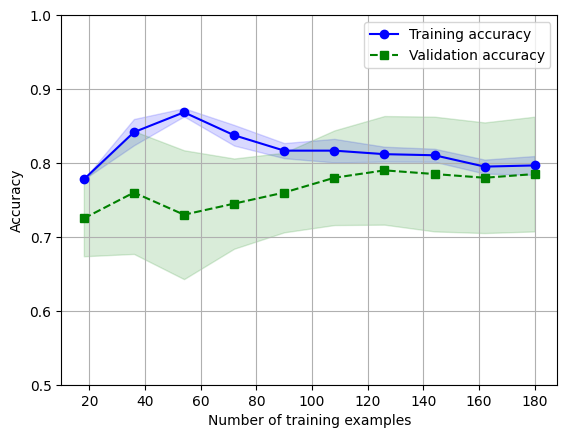

In [62]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator = best_lr_acc, X = X_train, y = y_train, cv = 10, n_jobs = -1, train_sizes = np.linspace(0.1,1,10))
train_mean, train_std= np.mean(train_scores, axis = 1), np.std(train_scores, axis = 1)
test_mean, test_std = np.mean(test_scores, axis= 1), np.std(test_scores, axis = 1)

plt.plot(train_sizes,train_mean, color = 'blue', marker = 'o', label = 'Training accuracy')
plt.plot(train_sizes, test_mean, color = 'green', linestyle = '--', marker = 's', label = 'Validation accuracy')

plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha = 0.15, color = 'blue')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha = 0.15, color = 'green')

plt.ylim([0.5,1])
plt.ylabel('Accuracy')
plt.grid()
plt.xlabel('Number of training examples')
plt.legend()
plt.show()

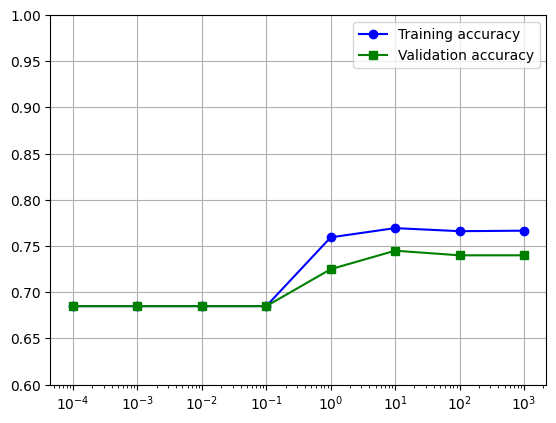

In [68]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(estimator= best_lr_kpca_acc, X = X_train, y = y_train, cv  = 10, param_name = 'logisticregression__C', 
param_range = C_range)

train_mean = np.mean(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)

plt.plot(C_range, train_mean, color = 'blue', marker = 'o', label = 'Training accuracy')
plt.plot(C_range, test_mean, color = 'green', marker = 's', label = 'Validation accuracy')
plt.grid()
plt.xscale('log')
plt.ylim([0.6, 1.0])
plt.legend()
plt.show()


In [69]:
print(best_lr_kpca_acc)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kernelpca', KernelPCA(kernel='rbf', n_components=6)),
                ('logisticregression',
                 LogisticRegression(C=10, random_state=1))])


## Random Forest

In [79]:
forest = RandomForestClassifier(random_state= 1)

pipe_rfc = make_pipeline(forest)
max_depth = [100,500,800]
n_trees = [100,400,10000]
param_grid_rfc = [{'randomforestclassifier__n_estimators': n_trees, 'randomforestclassifier__max_depth': max_depth, 'randomforestclassifier__criterion':['gini']}]

gs_rfc = GridSearchCV(estimator= pipe_rfc, param_grid = param_grid_rfc, scoring = 'accuracy', refit = True, cv  = 10)
gs_rfc.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier(random_state=1))]),
             param_grid=[{'randomforestclassifier__criterion': ['gini'],
                          'randomforestclassifier__max_depth': [100, 500, 800],
                          'randomforestclassifier__n_estimators': [100, 400,
                                                                   10000]}],
             scoring='accuracy')

In [80]:
print(pipe_rfc)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(random_state=1))])


In [825]:
pipe_rfc = make_pipeline(StandardScaler(), forest)


In [826]:
scores = cross_val_score(estimator= pipe_rfc, X = X_train, y = y_train, cv =10)
print('Score valutato con la k-fold validation:', np.mean(scores))

Score valutato con la k-fold validation: 0.834


In [827]:
param_range = [1,5,10,50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
param_grid = [{'randomforestclassifier__n_estimators': param_range, 'randomforestclassifier__criterion':['gini']}]
gs = GridSearchCV(estimator= pipe_rfc, param_grid= param_grid, scoring= 'accuracy', refit= True, cv = 10)

In [828]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(max_depth=100,
                                                               random_state=1))]),
             param_grid=[{'randomforestclassifier__criterion': ['gini'],
                          'randomforestclassifier__n_estimators': [1, 5, 10, 50,
                                                                   100, 200,
                                                                   300, 400,
                                                                   500, 600,
                                                                   700, 800,
                                                                   900,
                                                                   1000]}],
             scoring='accuracy')

In [829]:
print(gs.best_params_, gs.best_score_)

{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 400} 0.8520000000000001


In [857]:
pipe_rfc = gs.best_estimator_
pipe_rfc.fit(X_train, y_train)
scores = cross_val_score(estimator= pipe_rfc, X = X_train, y = y_train, cv = 10)
print(np.mean(scores))

0.8520000000000001


In [858]:
print('Accuracy del modello sul test data:', pipe_rfc.score(X_test, y_test))

Accuracy del modello sul test data: 0.84


## Random Forest + Feature selection

In [859]:
sbs = SequentialFeatureSelector(estimator = pipe_rfc, scoring = 'accuracy' )
sbs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=Pipeline(steps=[('standardscaler',
                                                     StandardScaler()),
                                                    ('randomforestclassifier',
                                                     RandomForestClassifier(max_depth=100,
                                                                            n_estimators=400,
                                                                            random_state=1))]),
                          scoring='accuracy')

In [860]:
features = sbs.get_feature_names_out(df_magic.columns[:-1])
print(features)

['Lenght' 'Width' 'Size' 'Alpha' 'Dist']


In [861]:
X_train_sbs = sbs.transform(X_train)
X_test_sbs = sbs.transform(X_test)

In [862]:
#print(pipe_lr)
pipe_rfc.fit(X_train_sbs, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=100, n_estimators=400,
                                        random_state=1))])

In [863]:
print(pipe_rfc.score(X_test_sbs, y_test))

0.85


## Random forest + PCA


In [876]:
pca = PCA(n_components = None)
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train_std, y_train, test_size= 0.3, random_state= 0 , stratify= y_train)
pca.fit(X_train_2)

PCA()

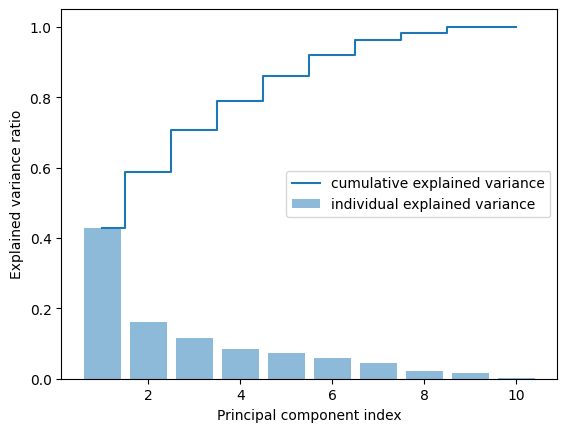

In [877]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)

plt.bar(range(1,11), pca.explained_variance_ratio_, alpha  = 0.5, align = 'center', label = 'individual explained variance')
plt.step(range(1,11), cum_var_exp , where = 'mid', label = 'cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc = 'best')
plt.show()

In [866]:
#pipe_rfc = make_pipeline(StandardScaler(), PCA(n_components=5), RandomForestClassifier(n_estimators= 400, criterion= 'gini', max_depth= 100, 
#random_state = 1)) 


In [878]:
for i in [1,2,3,4,5,6,7,8,9]:
    pca = PCA(n_components= i)
    X_train_pca = pca.fit_transform(X_train_2)
    X_val_pca = pca.transform(X_val)
    pipe_rfc.fit(X_train_pca, y_train_2)
    print(i, pipe_rfc.score(X_val_pca, y_val))

1 0.64
2 0.7666666666666667
3 0.7533333333333333
4 0.8066666666666666
5 0.82
6 0.8133333333333334
7 0.8066666666666666
8 0.8066666666666666
9 0.8066666666666666


In [879]:
pipe_rfc = make_pipeline(StandardScaler(), PCA(n_components=5), RandomForestClassifier(n_estimators= 400, criterion= 'gini', max_depth= 100, 
random_state = 1)) 
gs = GridSearchCV(estimator= pipe_rfc, param_grid= param_grid, scoring= 'accuracy', refit= True, cv = 10)


In [880]:
gs.fit(X_train, y_train)
print(gs.best_score_, gs.best_params_)

0.796 {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 1000}


In [881]:
pipe_rfc = gs.best_estimator_
pipe_rfc.fit(X_train, y_train)
print(pipe_rfc.score(X_test, y_test))

0.824


In [882]:
pipe_rfc.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=5)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=100, n_estimators=1000,
                                        random_state=1))])>